# **Lab 0: Preparation**

---
NOTE: This is a lab project accompanying the following book [MLF] and it should be used together with the book.

[MLF] *H. Jiang*, "[Machine Learning Fundamentals: A Concise Introduction](http://wiki.eecs.yorku.ca/user/hj/research:mlfbook)", Cambridge University Press, 2021.  ([bibtex](http://www.cse.yorku.ca/~hj/mlf-jiang.bib))

---



The purpose of this lab is to introduce *vectorization*-based programming style, which is essential for implementing machine learning algorithms using some high-level programming languages (such as Python, Matlab), and then give some recipes on how to load data sets that will be used in all projects in the book [MLF].  

*Prerequisites*: basic understanding on Python, Numpy and JAX.  

## **I. Programming via Vectorization**



*Vectorization* is a special programing style for numerical computation, in which we packs all arguments into vectors/matrices and casts all numerical operations as matrix operations. By doing so, we try to get rid of loops and array indexing so as to deliver clean and effecient programs even when they are written in high-level programming languages, such as Python, Matlab. 

**Vectorization**: programming using vectors, matrices, and even tensors without explicitly looping, indexing, conditioning over vector/matrix/tensor elements. 

**Advantages**: 
1.   vectorized codes are more concise and easier to read. 
2.   vectorized codes run much faster in high-level languages, such as Python/Numpy, Matlab and so on. 
3.   vectorized codes can easily utilize parallel units  in powerful computing hardwares (such as multi-core CPUs or GPUs) to yield further speed-up.


The key idea in vectorization-based programming is to use linear algebra techniques to pack the data into vectors / matrices /tensors. In the following, let us use two simple examples to explain how to write efficient vectorization-based codes, and further show how much faster these vectorized codes can run compared with the regular programming style (in either CPUs or GPUs). 

### **Example 0.1**
clipping all elements in a vector/matrix to  [0,1].

**1.1  POOR** programming style using loops, indexing and conditioning 

In [ ]:
def clip_loops(A):
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      if (A[i,j] > 1):
        A[i,j] = 1
      elif (A[i,j] < 0):
        A[i,j] = 0

  return A

**1.2** use a *numpy* function *clip( )* to do it efficiently 

In [ ]:
import numpy as np

A = np.clip(A,0,1)

**1.3** Running on a random matrix to compare their results and run-in speed. 

In [ ]:
import numpy as np

X = np.random.normal(size=(5000,784))*1.5

X1 = clip_loops(X)
X2 = np.clip(X,0,1)

print(np.sum((X1-X2)*(X1-X2)))

%timeit clip_loops(X)
%timeit np.clip(X,0,1)

0.0
1 loop, best of 5: 3.61 s per loop
100 loops, best of 5: 11.5 ms per loop


**1.4** Summary:


1.   Vectorized code is much more concise and easier to read. 
2.   Vectorization code is much faster than loops (about 300-400 times faster, 3.61 s vs 11.5 ms)

### **Example 0.2** 

Write a function to compute the sample covariance matrix from a set of data samples:
$$\mathcal{D} = \big\{ \mathbf{x}_1, \mathbf{x}_2, \cdots, \mathbf{x}_N \big\}$$
as
$$
\mathbf{S} =    \frac{1}{N} \,  \sum_{i=1}^N \, (\mathbf{x}_i - \bar{\mathbf{x}} ) \, (\mathbf{x}_i - \bar{\mathbf{x}} )^\intercal
$$
(NOTE: the sample covariance matrix is discussed in *Section 4.2 Linear Dimension Reduction*, which is the main backbone in some popular machine learning methods such as PCA and LDA.)

**2.1** regular (but poor) programing using loops 

In [ ]:
import numpy as np

## input: matrix X as N by d, each row is a feature vector of d dimensions
def cov_loops(X):
  N = X.shape[0]
  d = X.shape[1]

  # compute the mean
  mean = np.zeros((d))
  for i in range(N):
    for j in range(d):
      mean[j] += X[i,j]
  for j in range(d):
    mean[j] /= N

  # compute the sample covariance matrix
  S = np.zeros((d,d))
  z = np.zeros((d))
  for i in range(N):
    for j in range(d):
      z[j] = X[i,j] - mean[j]
    for m in range(d):
      for n in range(d):
        S[m,n] += z[m] * z[n]
  for m in range(d):
    for n in range(d):
      S[m,n] /=  N
    
  return S

**2.2** Vecctorized codes using *numpy* for CPUs

For the above sample convariance example, we use the following identity (refer to Q2.3 on page 64):
$$
\sum_{i=1}^m  \mathbf{x}_i  \mathbf{x}_i^\intercal = \mathbf{X}  \mathbf{X}^\intercal
$$

In [ ]:
import numpy as np

## input: matrix X as N by d, each row is a feature vector of d dimensions
def cov_vec(X):
  mean = np.mean(X, axis=0)

  return (X-mean) @ (X-mean).T / X.shape[0]

**2.3** Vectorized codes using JAX for GPUs

Vectorized codes can be further accelerated in GPUs using some python library such as JAX.

In [ ]:
import jax.numpy as jnp
from jax import jit

## input: matrix X as N by d, each row is a feature vector of d dimensions
@jit
def cov_jax(X):
  X = jnp.array(X)
  mean = jnp.mean(X, axis=0)

  return (X-mean) @ (X-mean).T / X.shape[0]

**2.4** Running on some random samples, and compare the results and running speed of the above three implementations.

In [ ]:
import numpy as np

# N=300 samples, whose dimensions are d=784 
X = np.random.normal(size=(300,784))

%timeit -n1 -r1  cov_loops(X)
%timeit -n3 -r3  cov_vec(X)
%timeit -n3 -r3  cov_jax(X)

S1 = cov_loops(X)
S2 = cov_vec(X)
S3 = cov_jax(X)

print(np.trace(S1), np.trace(S2), np.trace(S3))

1 loop, best of 1: 2min 23s per loop
3 loops, best of 3: 6.63 ms per loop
The slowest run took 1337.56 times longer than the fastest. This could mean that an intermediate result is being cached.
3 loops, best of 3: 613 µs per loop
779.8513112292864 779.8513112292862 779.8513


Compare CPU vs. GPU implementations on a larger sample set:

In [ ]:
import numpy as np

# N=5000 samples, whose dimensions are d=784 
X = np.random.normal(size=(5000,784))

%timeit cov_vec(X)
%timeit cov_jax(X)

S2 = cov_vec(X)
S3 = cov_jax(X)

print( np.trace(S2), np.trace(S3))

1 loop, best of 5: 1.18 s per loop
The slowest run took 31.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 7.92 ms per loop
783.0682494218952 783.06824


**2.5** Summary:

1.   Vectorization is about 20000+ times faster than loops (143s vs. 6.63ms)
2.   GPUs can further speed it up about 10 times (6.63ms vs 0.613ms) 
3.   GPUs can accelerate more for larger matrices, about 150+ times faster at above (1.18s vs 7.92ms)




In [ ]:
# show the GPU type used in the above computation

!nvidia-smi

Tue Jan 11 20:29:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## **II. Loading Data Sets**


### 1. **loading the MNIST data set**

The MNIST data set is used in Lab Project I (page 92), Lab Project II (page 129) and Lab Project IV (page 200).

1. First of all, download the original MNIST data [here](https://drive.google.com/drive/folders/1r20aRjc2iu9O3kN3Xj9jNYY2uMgcERY1?usp=sharing) using ```gdown```. The data will be located in a folder called 'MNIST', including four files: _train-images-idx3-ubyte_,  _train-labels-idx1-ubyte_,   _t10k-images-idx3-ubyte_, _t10k-labels-idx1-ubyte_. 


In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1r20aRjc2iu9O3kN3Xj9jNYY2uMgcERY1 2> /dev/null

Processing file 1Jf2XqGR7y1fzOZNKLJiom7GmZZUzXhfs t10k-images-idx3-ubyte
Processing file 1qiYu9dW3ZNrlvTFO5fI4qf8Wtr8K-pCu t10k-labels-idx1-ubyte
Processing file 1SnWvBcUETRJ53rEJozFUUo-hOQFPKxjp train-images-idx3-ubyte
Processing file 1kKEIi_pwVHmabByAnwZQsaMgro9XiBFE train-labels-idx1-ubyte
Building directory structure completed


2. i) Use idx2numpy to convert idx to numpy arrays

In [ ]:
# install idx2numpy

!pip install idx2numpy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import idx2numpy
import numpy as np

# load training images and labels 
train_data=idx2numpy.convert_from_file('MNIST/train-images-idx3-ubyte')
train_data = np.reshape(train_data,(60000,28*28))
train_label = idx2numpy.convert_from_file('MNIST/train-labels-idx1-ubyte')
print(train_data.shape)
print(train_label.shape)

# load testing images and labels 
test_data=idx2numpy.convert_from_file('MNIST/t10k-images-idx3-ubyte')
test_data = np.reshape(test_data,(10000,28*28))
test_label = idx2numpy.convert_from_file('MNIST/t10k-labels-idx1-ubyte')
print(test_data.shape)
print(test_label.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


2.    ii) OR use python-mnist to load into numpy

In [ ]:
# install python_mnist

!pip install python_mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mnist import MNIST
import numpy as np
mnist_loader = MNIST('MNIST')
train_data, train_label = mnist_loader.load_training()
test_data, test_label = mnist_loader.load_testing()
train_data = np.array(train_data)
train_label = np.array(train_label)
test_data = np.array(test_data)
test_label = np.array(test_label)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


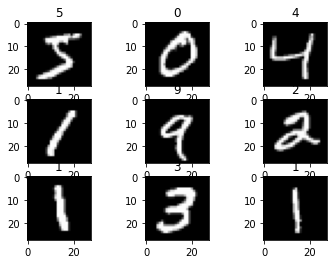

In [ ]:
# use a matplotlib function to display some MNIST images

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def show_img(num):
  img = train_data[num,:]
  img = img.reshape(28,-1)
  print(str(img.shape) + '  No.' +  str(num) + '  label:' + str(train_label[num]))
  plt.imshow(img, cmap='gray')
  plt.show()

fig = plt.figure()

for i in range(9):
  img = train_data[i,:]
  img = img.reshape(28,-1)
  ax = fig.add_subplot(3,3,i+1)
  ax.title.set_text(str(train_label[i]))
  plt.imshow(img, cmap='gray')

plt.show(block=True)
    

### **2. Loading the Boston House data set** 

The Boston House data set is used in Q7.7 on page 150.

Download [boston.csv](https://drive.google.com/file/d/1UOJmn44xf-WW0KydM81eytMHNbdlHr5o/view?usp=sharing) using ```gdown```. 
Refer to [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) for the description of the data.

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/12L9XNwhIH2wQBa4-IdQrhsrtgRFbeIMZ 2> /dev/null

Processing file 1IZf0tFGW3Zv3Ax5gxKgnklHe1DUI7CAI boston.csv
Building directory structure completed


In [ ]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv('Boston/boston.csv', header=None)
data_rows = np.reshape(raw_data.to_numpy(), (506,14))
data = data_rows[:,:13]
target = data_rows[:,13]

print(data.shape)
print(target.shape)


(506, 13)
(506,)


### **3. Loading the Ames Housing data set** 

The Ames Housing data set is used in Lab Project V (page 216).

Download the data set from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) or [here](https://drive.google.com/drive/folders/1w2hM-TIzvFFYHp_5JCVEGTA3DWNNskx9?usp=sharing) using ```gdown```. The data description is [here](https://drive.google.com/file/d/1sSEHUamh5JJGxMvk17GkrgHBpzUf7Q-n/view?usp=sharing).

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1w2hM-TIzvFFYHp_5JCVEGTA3DWNNskx9 2> /dev/null

Processing file 1sSEHUamh5JJGxMvk17GkrgHBpzUf7Q-n data_description.txt
Processing file 1d_hN2NxCaIn3IlxPXximPUajdnkpyGff sample_submission.csv
Processing file 1GX9ZPzZ9sH8QvrqESnLrsB78O1vUwcDW test.csv
Processing file 1ATUfJGfaFjdZkWC2j46y_00iDQn_NLE8 train.csv
Building directory structure completed


In [ ]:
import pandas as pd

train_dataframe = pd.read_csv("AmesHouse/train.csv")
test_dataframe = pd.read_csv("AmesHouse/test.csv")

print(train_dataframe.shape)
print(test_dataframe.shape)

# WARNING: both train_dataframe and test_dataframe contain symbolic features (refer to the data description)
#          they need be pre-processed to numbers prior to model training and testing

(1460, 81)
(1459, 80)


### **4. Loading the MLF Gaussian data set** 

The MLF Gaussian data set is used in Lab Project VI (page 287).

Download the data set from [here](https://drive.google.com/drive/folders/1agkY7npAHzav-e1yYIVBJNgfux5AsmlX?usp=sharing) using ```gdown```: 

In [ ]:
!gdown --folder https://drive.google.com/drive/folders/1agkY7npAHzav-e1yYIVBJNgfux5AsmlX 2> /dev/null

Processing file 115nnh9K_ry8iyHg6VwtcEXQM-tYgog8f test-gaussian.csv
Processing file 1kaSuLbSmpYx3gLMqYe8S_EWU86nmq_CV train-gaussian.csv
Building directory structure completed


In [ ]:
import pandas as pd

train_dataframe = pd.read_csv("MLF-Gauss/train-gaussian.csv")
test_dataframe = pd.read_csv("MLF-Gauss/test-gaussian.csv")
train_data = train_dataframe.to_numpy()
test_data = test_dataframe.to_numpy()

print(train_data.shape)
print(test_data.shape)

(1891, 4)
(830, 4)


## **Exercises**

### **Problem 0.1:**
Write a program to compute pair-wise Euclean distances (i.e., $L_2$ norm) between all vectors in a set of data samples:
$$\mathcal{D} = \big\{ \mathbf{x}_1, \mathbf{x}_2, \cdots, \mathbf{x}_N \big\}$$
where each $\mathbf{x}_i \in \mathbb{R}^d$.
Store all these pair-wise distances in a symmetric marix $\mathbf{E} \in \mathbb{R}^{N \times N}$, where each element $e_{ij}$ indicates the distance between $\mathbf{x}_i$ and $\mathbf{x}_j$. 

1.   Implement it using regular loop-based programing style. 

2.   Implement it use vectorization.

3.   Generate some random samples, compare the above two implementations in terms of running speed. 



### **Problem 0.2:**

Refer to Q6.8 (page 130),  write some programs to compute the SVM matrix $Q$ for three different kernel types: linear, polynomial and RBF functions. 

1.   Implement it using regular loop-based programing style.

2.   Use vectorization to re-write vectorized codes to compute the matrix $Q$ for all three kernel types. 

3.   Generate some random samples, compare the above two implementations in terms of running speed. 